
# Houston, Texas, United States AOD Analysis

This notebook performs an analysis on Aerosol Optical Depth (AOD) data for Houston. The goal is to explore and visualize the AOD data, understand its distribution, and identify any significant patterns or trends.



# Houston AOD Notebook

This notebook performs an analysis on Aerosol Optical Depth (AOD) data for Houston. The goal is to explore and visualize the AOD data, understand its distribution, and identify any significant patterns or trends. This notebook includes reading in Moderate Resolution Imaging Spectroradiomater (MODIS) AOD data, plotting decadal averages, plotting  National Land Cover Database (NLCD) urbanization, reading in comma separated variable (csv) files depicting AOD trends for different areas of interest.

Below are explanations for the key steps involved in this analysis.

References:

MODIS: https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD19A2_GRANULES

NLCD: https://www.mrlc.gov/

Pandas:https://pandas.pydata.org/


# Import and Install Necessary Packages

In [2]:
!pip install statsmodels
!pip install geopandas
!pip install rasterstats
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 14.2 MB/s eta 0:00:00


In [3]:
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import rasterio
from rasterio.plot import show
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
import fiona
from osgeo import ogr
import numpy as np
from rasterio.features import geometry_mask
from matplotlib import axis


### Compare 2000-2009 & 2010-2019 Mean MODIS AOD using Appropriate Tiffs

This section contains code to read or load the data. It is a crucial step as it brings the data into the notebook for analysis.


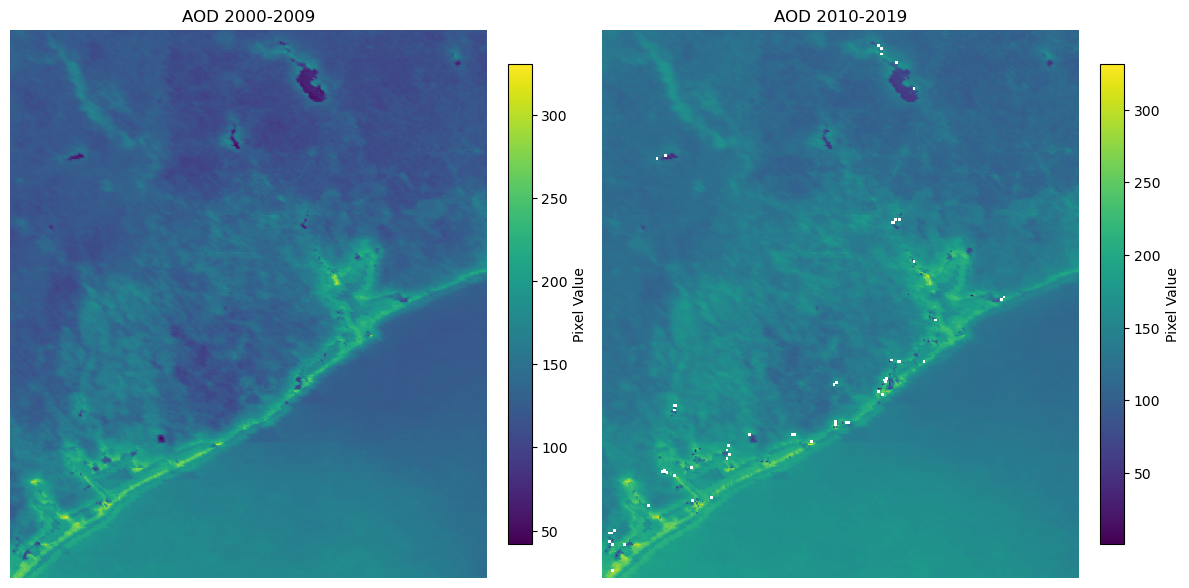

In [ ]:
with rasterio.open('FINAL-houston-data/AOD_2000_2009_cog.tif') as src1:
    # Read the raster data
    data1 = src1.read(1)  # Assuming a single band raster, adjust if necessary

# Read the second TIFF file
with rasterio.open('FINAL-houston-data/AOD_2010_2019_cog.tif') as src2:
    # Read the raster data
    data2 = src2.read(1)  # Assuming a single band raster, adjust if necessary

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size as needed

# Plot the first TIFF in the first subplot
axs[0].imshow(data1, cmap='viridis')
axs[0].set_title('AOD 2000-2009')
axs[0].axis('off')

# Plot the second TIFF in the second subplot
axs[1].imshow(data2, cmap='viridis')
axs[1].set_title('AOD 2010-2019')
axs[1].axis('off')

# Add colorbars to the subplots
cbar1 = fig.colorbar(axs[0].imshow(data1, cmap='viridis'), ax=axs[0], fraction=0.046, pad=0.04)
cbar1.set_label('Pixel Value')
cbar2 = fig.colorbar(axs[1].imshow(data2, cmap='viridis'), ax=axs[1], fraction=0.046, pad=0.04)
cbar2.set_label('Pixel Value')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### Plot MODIS AOD Difference Map

This section contains code plot the MODIS AOD difference from the decades of interest.


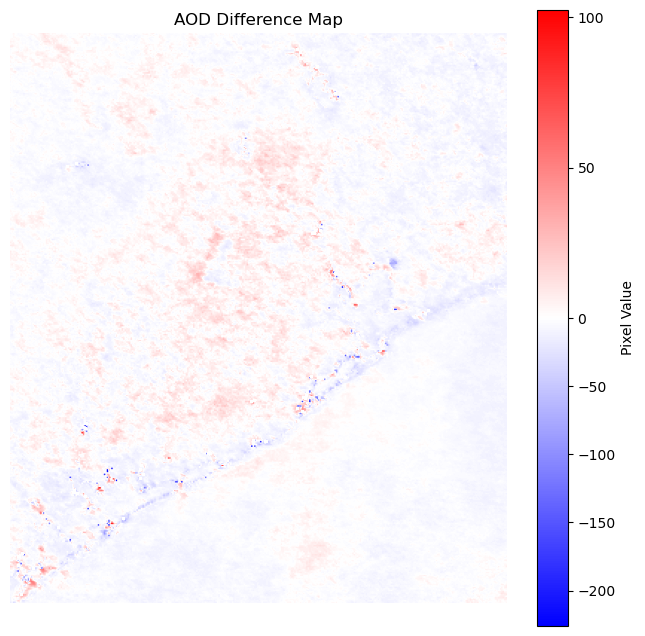

In [ ]:
# Read the TIFF file
with rasterio.open('FINAL-houston-data/AOD_2010_2019_diff.tif') as src:
    # Read the raster data
    data = src.read(1)  # Assuming a single band raster, adjust if necessary

    # Get the spatial transform (georeferencing information)
    transform = src.transform

norm = colors.TwoSlopeNorm(vmin = np.nanmin(data), vcenter=0, vmax=np.nanmax(data))
# Plot the TIFF data
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.imshow(data, cmap = 'bwr', norm=norm)

# Add a colorbar
plt.colorbar(label='Pixel Value')

# Add labels and title
plt.title('AOD Difference Map')
plt.axis('off')

# Display the plot
plt.show()


### Houston NLCD Urbanization for 2001 and 2019

This section contains code to read in NLCD urbanization data for 2001 and 2019 and plots those values.


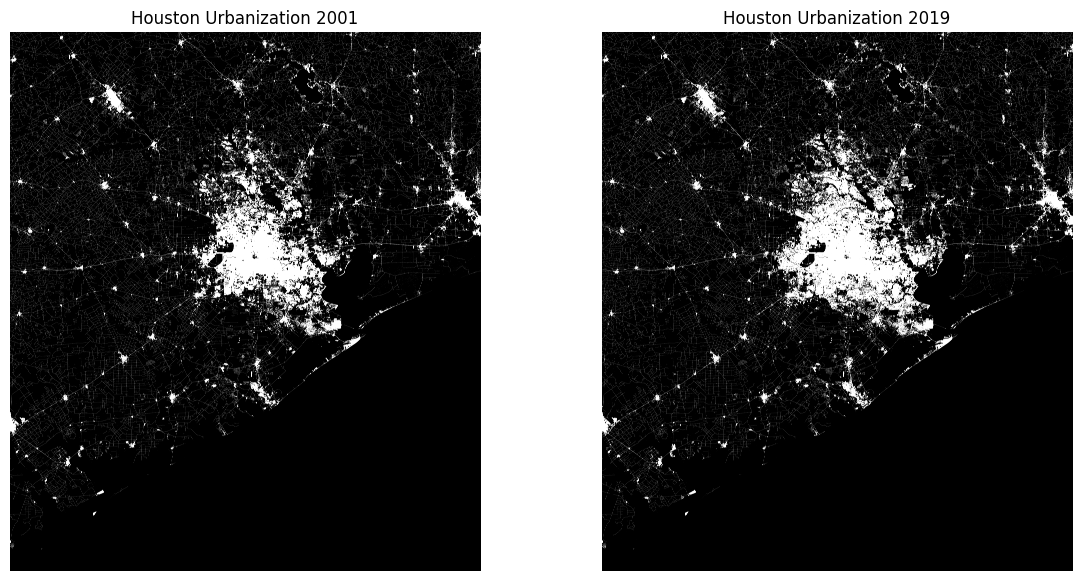

In [4]:
# File paths
file_2001 = 'FINAL-houston-data/HOUS_DFAL_landcover_2001-2001.tif'
file_2019 = 'FINAL-houston-data/HOUS_DFAL_landcover_2019-2019.tif'

# Urbanization values in NLCD
urban_values = [21, 22, 23, 24]

# Function to create a binary mask
def create_urban_mask(data, urban_values):
    mask = np.isin(data, urban_values).astype(np.uint8)
    return mask

# Read and process the 2001 TIFF file
with rasterio.open(file_2001) as src_2001:
    data_2001 = src_2001.read(1)
    urban_mask_2001 = create_urban_mask(data_2001, urban_values)

# Read and process the 2019 TIFF file
with rasterio.open(file_2019) as src_2019:
    data_2019 = src_2019.read(1)
    urban_mask_2019 = create_urban_mask(data_2019, urban_values)

# Plotting the binary masks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

ax1.imshow(urban_mask_2001, cmap='gray')
ax1.set_title('Houston Urbanization 2001')
ax1.axis('off')

ax2.imshow(urban_mask_2019, cmap='gray')
ax2.set_title('Houston Urbanization 2019')
ax2.axis('off')

plt.show()


### Take Urbanization Difference and Visualize

This cell contains code to calculate the difference in urbanization from 2001 and 2019 and visualize that difference.


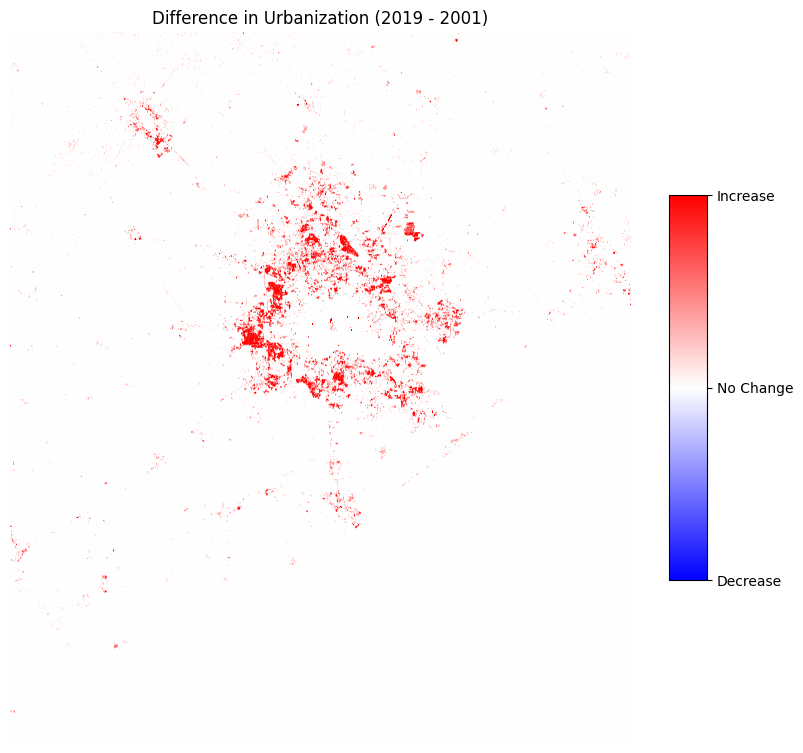

In [5]:
# Calculate the difference mask
difference_mask = urban_mask_2019 - urban_mask_2001

# Plotting the difference mask
fig, ax = plt.subplots(figsize=(10, 10))

cax = ax.imshow(difference_mask, cmap='bwr', vmin=-1, vmax=1)
ax.set_title('Difference in Urbanization (2019 - 2001)')
ax.axis('off')

# Add a colorbar to interpret the differences
cbar = fig.colorbar(cax, orientation='vertical', shrink=0.5, aspect=10)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['Decrease', 'No Change', 'Increase'])

plt.show()


### Plotting Galveston Bay AOD Trend

This section contains code to read in the Galveston Bay CSV and visualizes the time series.


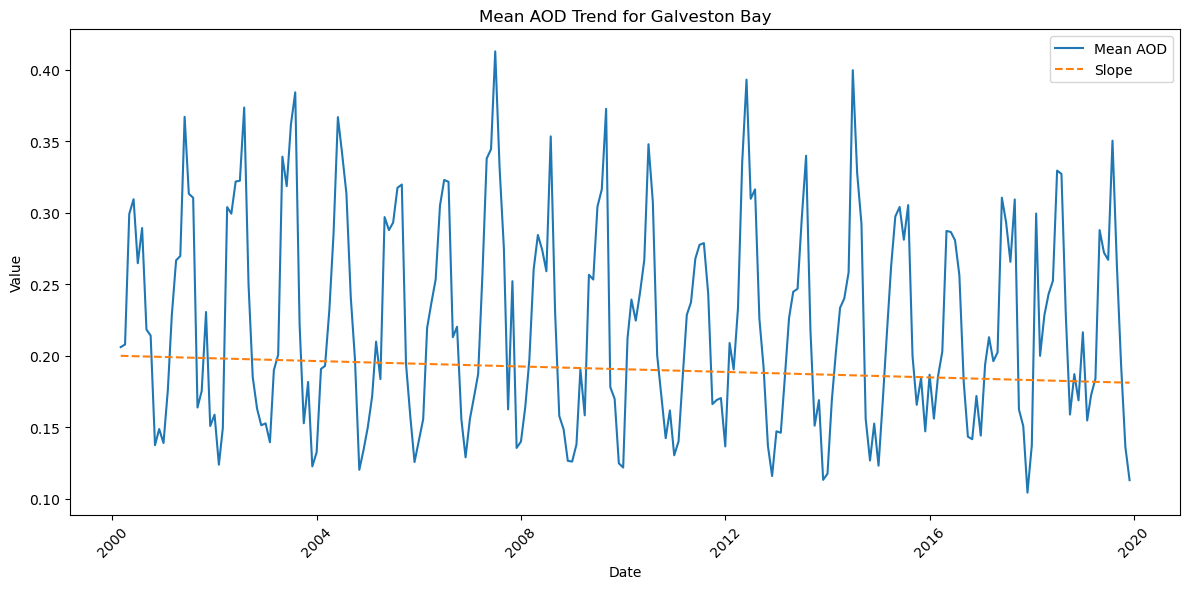

In [ ]:
# Read the CSV
df = pd.read_csv('FINAL-houston-data/data_final_baytown_with_adjusted_slope.csv')

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Plot the data
plt.figure(figsize=(12, 6))

# Plot Mean AOD
plt.plot(df['Date'], df['Mean AOD'], label='Mean AOD', linestyle='-')

# Plot Slope
plt.plot(df['Date'], df['Slope'], label='Slope', linestyle='--')

# Customize the plot
plt.title('Mean AOD Trend for Galveston Bay')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


### Time series for the Western Suburbs

This section contains code to read in the western suburbs CSV and plot the time series.


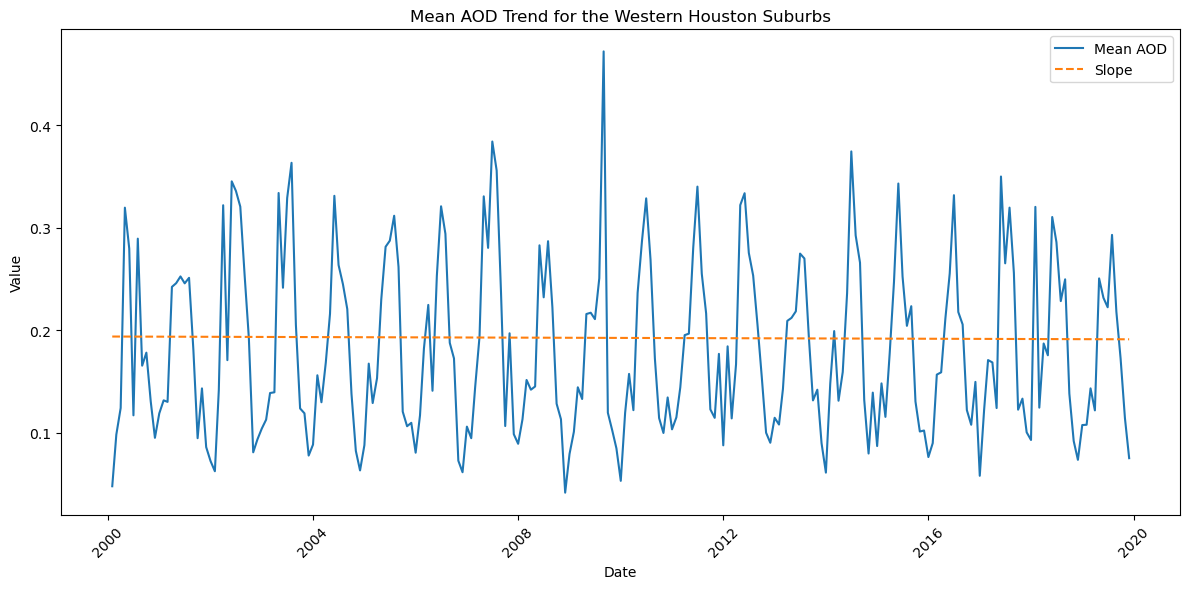

In [ ]:
# Read the CSV
df = pd.read_csv('FINAL-houston-data/data_final_west_with_adjusted_slope.csv')

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Plot the data
plt.figure(figsize=(12, 6))

# Plot Mean AOD
plt.plot(df['Date'], df['Mean AOD'], label='Mean AOD', linestyle='-')

# Plot Slope
plt.plot(df['Date'], df['Slope'], label='Slope', linestyle='--')

# Customize the plot
plt.title('Mean AOD Trend for the Western Houston Suburbs')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


### Time series of IAH

This section contains code to read in the IAH csv and plot the time series.


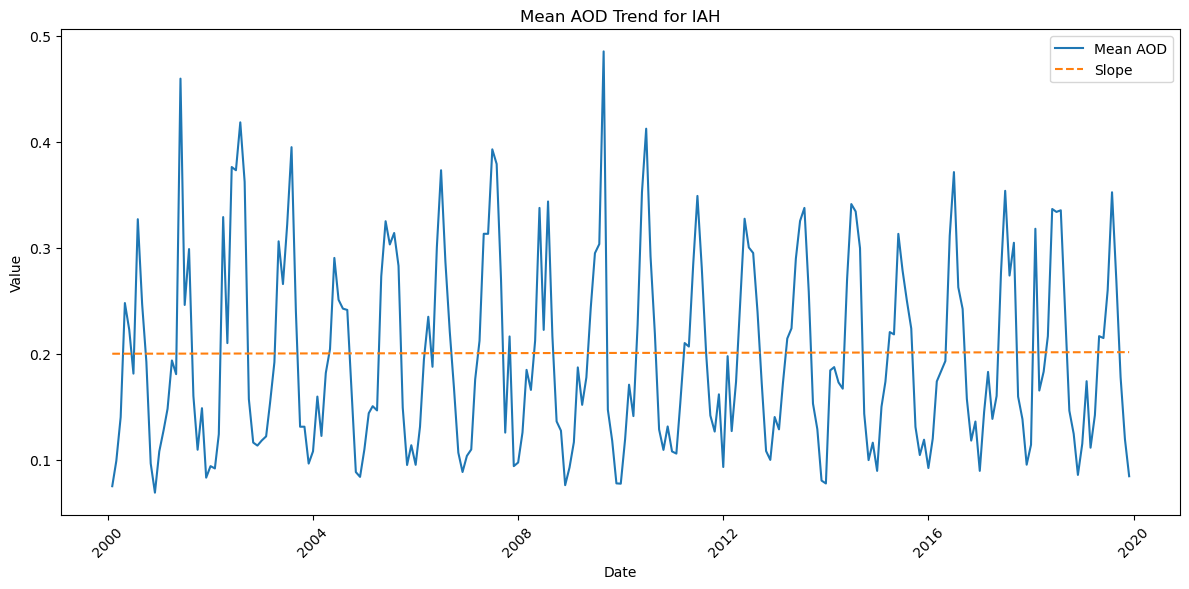

In [ ]:
# Read the CSV
df = pd.read_csv('FINAL-houston-data/data_final_IAH_with_adjusted_slope.csv')

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Plot the data
plt.figure(figsize=(12, 6))

# Plot Mean AOD
plt.plot(df['Date'], df['Mean AOD'], label='Mean AOD', linestyle='-')

# Plot Slope
plt.plot(df['Date'], df['Slope'], label='Slope', linestyle='--')

# Customize the plot
plt.title('Mean AOD Trend for IAH')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


## Summary

In this notebook, we performed an analysis on the AOD data and urbanization for Houston. We explored the data, visualized key trends, and drew insights about the AOD distribution and its implications. The analysis provided a comprehensive understanding of the AOD patterns in Houston.
